In [160]:
import numpy as np
from sklearn.decomposition import NMF
import time
import copy
import math

In [2]:
X = np.array(np.random.choice([0,1],(100,20)))

In [3]:
X

array([[0, 1, 0, ..., 1, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 1],
       [1, 0, 0, ..., 1, 0, 1]])

In [177]:
#use the same init
W0=np.random.random((X.shape[0],n_factors))
H0=np.random.random((n_factors,X.shape[1]))
print(W0.max(), W0.min(), W0.mean(), np.linalg.norm(W0))
print(H0.max(), H0.min(), H0.mean(), np.linalg.norm(H0))

0.9999198397591527 0.0012847959517654495 0.5050774024981401 11.696617063902842
0.9884203699164539 0.01812722522682697 0.5960600620235329 5.800078484076025


In [258]:
%%time
n_factors=4
nmf = NMF(n_components=n_factors, init='custom',max_iter=500)
W = nmf.fit_transform(X,W=W0.astype(np.double),H=H0.astype(np.double)) #corresponding to the U matrix
H = nmf.components_ #corresponding to the V matrix
print(W.shape, H.shape)
print(W.max(), W.min(), W.mean(), np.linalg.norm(W))
print(H.max(), H.min(), H.mean(), np.linalg.norm(H))
print(nmf.get_params())

(100, 4) (4, 20)
0.7688247955222398 0.0 0.1934709000385137 5.095430951156261
3.8199864449578453 0.0 0.6750046714050557 8.898555345810424
{'alpha': 0.0, 'beta_loss': 'frobenius', 'init': 'custom', 'l1_ratio': 0.0, 'max_iter': 500, 'n_components': 4, 'random_state': None, 'shuffle': False, 'solver': 'cd', 'tol': 0.0001, 'verbose': 0}
CPU times: user 0 ns, sys: 15.6 ms, total: 15.6 ms
Wall time: 11.9 ms


In [251]:
nmf.n_iter_

208

In [254]:
# manual decomposition
def updateU(X,U,V,n_factors,gamma=0.01):
    perm = np.array(range(n_factors))
    np.random.shuffle(perm)    
    #Uc=copy.deepcopy(U)
    for k in perm:
        for i in range(X.shape[0]):
            grad=0
            Z=0
            for j in range(X.shape[1]):
                grad+=(X[i,j]-np.dot(U[i,:],V[:,j])+U[i,k]*V[k,j])*V[k,j]
                Z += V[k,j]*V[k,j] 
#             grad =  np.sum(V[k,:]*(X[i,:]-np.dot(U[i,:],V[:])+(U[i,k]*V[k,:])))   
#             Z = np.sum(np.square(V[k,:]))    
            U[i,k]=(1-gamma)*U[i,k]+gamma*(grad/Z-U[i,k])  #moving average    
    return U         

def updateV(X,U,V, n_factors,gamma=0.01):
    perm = np.array(range(n_factors))
    np.random.shuffle(perm)
    #Vc=copy.deepcopy(V)
    for k in perm:
        for j in range(X.shape[1]):
#             grad=0
#             Z=0
#             for i in range(X.shape[0]):
#                 grad += (X[i,j]-np.dot(U[i,:],V[:,j])+U[i,k]*V[k,j])*U[i,k]
#                 Z += U[i,k]*U[i,k]
            grad =  np.sum(U[:,k]*(X[:,j]-np.dot(U[:],V[:,j])+V[k,j]*U[:,k]))   
            Z = np.sum(np.square(U[:,k]))  
            V[k,j]=(1-gamma)*V[k,j]+gamma*(grad/Z-V[k,j])   #moving average  
            
    return V

     

def decomposeMatrixU(X,U,V,n_factors):
    for r in range(0,X.shape[0]):
        for s in range(0,n_factors):
            m_array=np.array(X[r,:])
            v_array=np.array(V[s,:])
            v_array[np.isnan(m_array)]=np.nan
            # print m_array
            # print v_array
            denominator=np.nansum(np.square(v_array))
            # print denominator
            sum_array=np.matmul(U[r,:],V[:])-(U[r,s]*V[s,:])
            # # print sum_array
            numerator=np.nansum(V[s,:]*(m_array-sum_array))
            # numerator = np.nansum(V[s, :] * sum)
            # print numerator
            U[r,s]=float(numerator)/denominator
    return U

def decomposeMatrixV(X,U,V,n_factors):
    for s in range(0,X.shape[1]):
        for r in range(0,n_factors):
            m_array=np.array(X[:,s])
            u_array=np.array(U[:,r])
            u_array[np.isnan(m_array)]=np.nan
            # print m_array
            # print v_array
            denominator=np.nansum(np.square(u_array))
            # print denominator
            sum_array = np.matmul(U[:], V[:,s]) - (V[r, s] * U[:, r])
            # print sum_array
            numerator = np.nansum(U[:, r] * (m_array - sum_array))
            # print numerator
            V[r,s]=float(numerator)/denominator

    return V

In [222]:
U.shape

(100, 4)

In [223]:
V.shape

(4, 20)

In [224]:
np.matmul(U[5,:],V[:,5])

0.987611081495809

In [228]:
ss = np.matmul(U[5,:],V[:])-(U[5,2]*V[2,:])
ss.shape

(20,)

In [242]:
def NMF1(X,U,V,n_factors,itr=500,tol=0.0001,gamma=0.1):
    i=0
    ut = math.inf
    vt = math.inf
    while (i < itr)and((ut>tol)or(vt>tol)):
        Uc = copy.deepcopy(U)
        Vc = copy.deepcopy(V)
        U = updateU(X, U, V, n_factors,gamma)
        V = updateV(X, U, V, n_factors,gamma)
        ut = np.linalg.norm(Uc-U)
        vt = np.linalg.norm(Vc-V)
        i+=1
#         print(i)
#         print(Uc-U)
#         print('----')
#         print(Vc-V)
    meta=[i,ut,vt]    
    return U, V, meta    

def NMF3(X,U,V,n_factors,itr=500,tol=0.0001,gamma=0.01):
    i=0
    ut = math.inf
    vt = math.inf     
    while (i < itr)and((ut>tol)or(vt>tol)):
        Uc = copy.deepcopy(U)
        Vc = copy.deepcopy(V)
        U = decomposeMatrixU(X, U, V, n_factors)
        V = decomposeMatrixV(X, U, V, n_factors)
        ut = np.linalg.norm(Uc-U)
        vt = np.linalg.norm(Vc-V)
        i+=1
    meta=[i,ut,vt]    
    return U, V, meta 


In [256]:
%%time
n_factors=4
U0 = copy.deepcopy(W0)
V0= copy.deepcopy(H0)
U, V, meta = NMF1(X,U0,V0, n_factors,itr=1000)
print(U.max(), U.min(), U.mean(), np.linalg.norm(U))
print(V.max(), V.min(), V.mean(), np.linalg.norm(V)) 
print(meta)

0.6319241363195505 -0.08579651660109754 0.26618831867116954 6.011534977518354
0.7170860558815941 -0.016879735734705227 0.35722062599171267 3.495352367096476
[676, 9.9932928606872e-05, 5.645530880129517e-05]
CPU times: user 5.48 s, sys: 15.6 ms, total: 5.5 s
Wall time: 5.46 s


In [263]:
np.linalg.norm(W-U)/(W.shape[0]*W.shape[1])

0.00813984187728096

In [264]:
np.linalg.norm(H-V)/(H.shape[0]*H.shape[1])

0.0819135651467521

In [266]:
np.abs(W-U).max()

0.45553819404999096

In [267]:
np.abs(H-V).max()

3.1528629780423176

In [257]:
n_factors=4
U0 = copy.deepcopy(W0)
V0= copy.deepcopy(H0)
U, V, meta = NMF1(X,U0,V0, n_factors,itr=1000,gamma=0.01)
print(U.max(), U.min(), U.mean(), np.linalg.norm(U))
print(V.max(), V.min(), V.mean(), np.linalg.norm(V)) 
print(meta)

0.6914379259324408 -0.11191990704326878 0.2865170759786061 6.410627771934041
0.6671234669155278 -0.00011333148372243256 0.3331174343683225 3.228996215865496
[1000, 0.0011192894479192213, 0.0005624045502499443]


In [248]:
%%time
n_factors=4
U0 = copy.deepcopy(W0)
V0= copy.deepcopy(H0)
U, V, meta = NMF3(X,U0,V0, n_factors,itr=500, gamma=0.01)
print(U.max(), U.min(), U.mean(), np.linalg.norm(U))
print(V.max(), V.min(), V.mean(), np.linalg.norm(V)) 
print(meta)

1.5523637237972334 -2.092333532178523 0.18197799476995008 11.599558107582803
1.4963437813150864 -0.4678873733180615 0.583189184133489 6.1145425348572084
[370, 9.919717358842047e-05, 2.0977671109825914e-05]
CPU times: user 5.69 s, sys: 0 ns, total: 5.69 s
Wall time: 5.7 s


In [268]:
Wstat=[]
Hstat=[]
Ustat=[]
Vstat=[]

for _ in range(20):
    nmf = NMF(n_components=4, init='custom')
    W = nmf.fit_transform(X,W=W0.astype(np.double),H=H0.astype(np.double)) #corresponding to the U matrix
    H = nmf.components_
    Wstat.append([W.max(), W.min(), W.mean(), np.linalg.norm(W)])
    Hstat.append([H.max(), H.min(), H.mean(), np.linalg.norm(H)])   
    
    U0 = copy.deepcopy(W0)
    V0= copy.deepcopy(H0)
    U, V, meta = NMF1(X,U0,V0, n_factors,itr=500)
    Ustat.append([U.max(), U.min(), U.mean(), np.linalg.norm(U)])
    Vstat.append([V.max(), V.min(), V.mean(), np.linalg.norm(V)])
    

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline

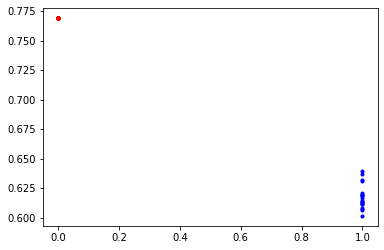

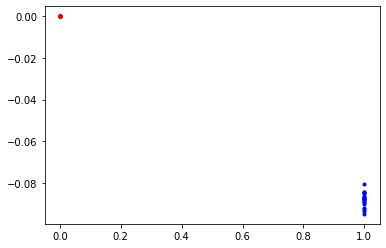

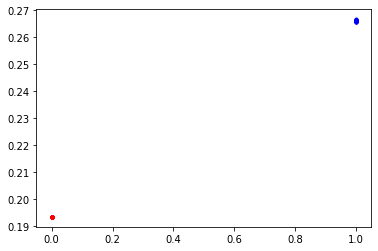

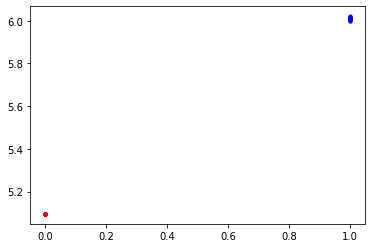

In [272]:
Ws = np.array(Wstat)
Us = np.array(Ustat)
for k in range(Ws.shape[1]):
    plt.plot(np.zeros(Ws[:,k].shape),Ws[:,k],'r.')
    plt.plot(np.ones(Us[:,k].shape),Us[:,k],'b.')
    plt.show()

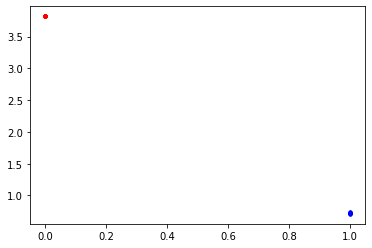

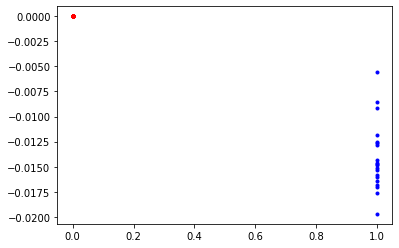

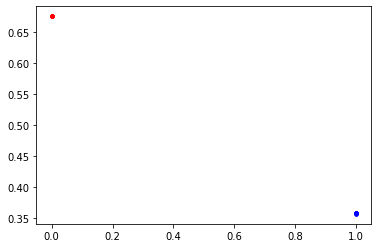

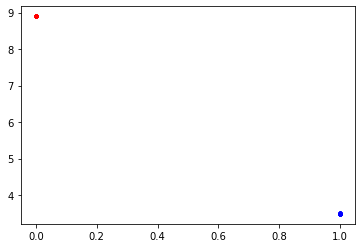

In [273]:
Hs = np.array(Hstat)
Vs = np.array(Vstat)
for k in range(Ws.shape[1]):
    plt.plot(np.zeros(Hs[:,k].shape),Hs[:,k],'r.')
    plt.plot(np.ones(Vs[:,k].shape),Vs[:,k],'b.')
    plt.show()

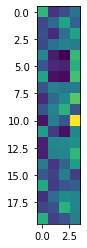

In [277]:
plt.imshow((W-U)[:20])

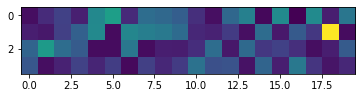

In [278]:
plt.imshow((H-V)[:,:20])

In [285]:
print((W-U).max(),(W-U).min(),(W-U).mean())

0.39585780763081174 -0.35908360225435765 -0.07284012837296377


In [284]:
print((H-V).max(),(H-V).min(),(H-V).mean())

3.1118537210500077 -0.46330538244013336 0.3180047581068767
